<a href="https://colab.research.google.com/github/Avenge-PRC777/OpenSourceLLM_infer_and_finetune/blob/main/main_notebook_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up endpoint

In [ ]:
!pip install openai

In [ ]:
import openai

In [ ]:
openai.api_key = open("openapi_key.txt", "r", encoding = "utf-8").read().strip()

In [ ]:
response = openai.Completion.create(
  model="text-davinci-003",
  prompt="Write a tagline for an ice cream shop."
)

In [ ]:
response

<OpenAIObject text_completion id=cmpl-7qWc410grguZOf1x3czjz31vdBdFW at 0x7e082ca3a250> JSON: {
  "warning": "This model version is deprecated. Migrate before January 4, 2024 to avoid disruption of service. Learn more https://platform.openai.com/docs/deprecations",
  "id": "cmpl-7qWc410grguZOf1x3czjz31vdBdFW",
  "object": "text_completion",
  "created": 1692752776,
  "model": "text-davinci-003",
  "choices": [
    {
      "text": "\n\n\"Cool down with delicious flavors at our ice cream shop!\"",
      "index": 0,
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 10,
    "completion_tokens": 14,
    "total_tokens": 24
  }
}

In [ ]:
for choice in response["choices"]:
    print(choice["text"])



"Cool down with delicious flavors at our ice cream shop!"


## Understanding inference parameters

https://platform.openai.com/docs/deprecations
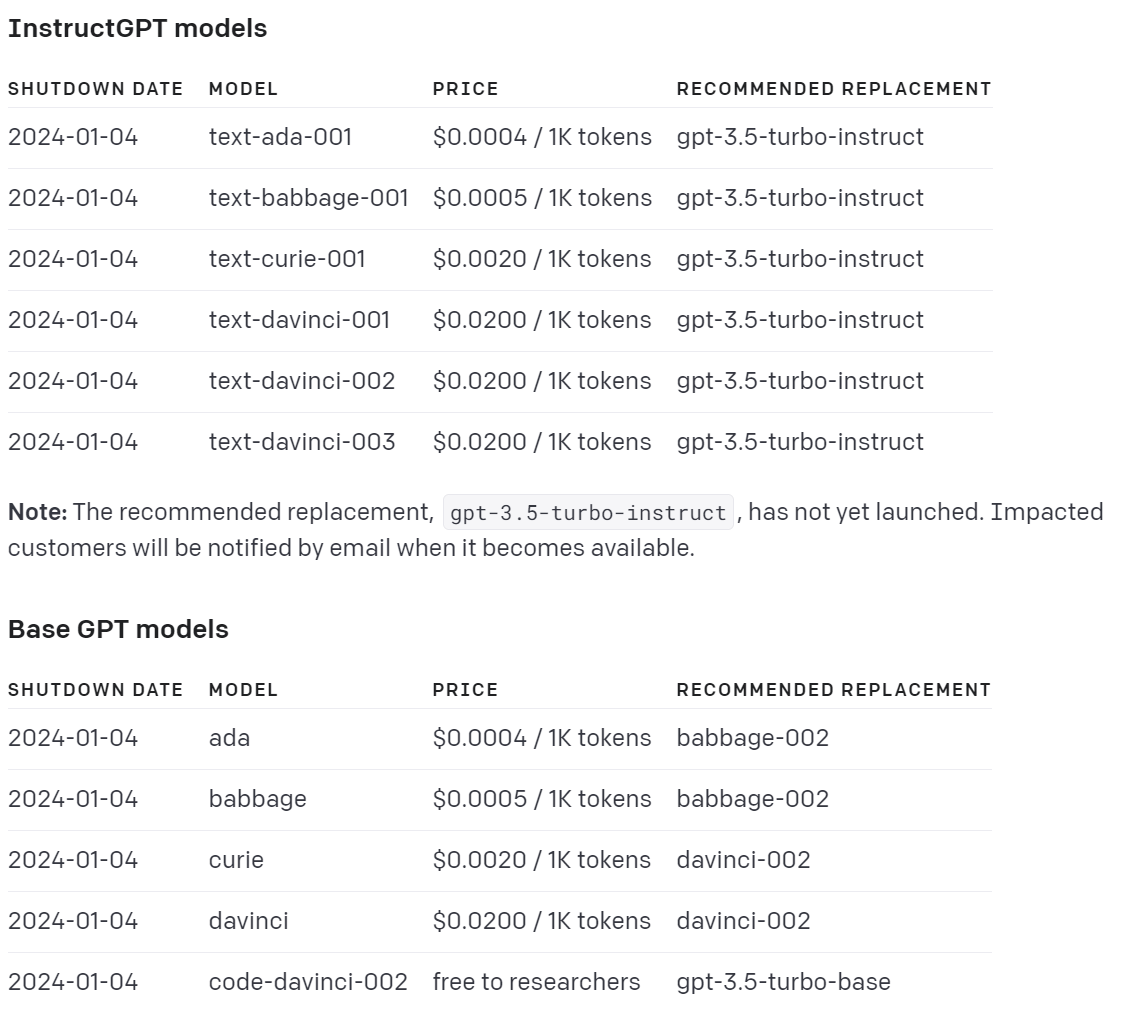

## Function parameters
- **model="text-davinci-003"**: This specifies the **name of the model** to use for the request. text-davinci-003 is an improved version of text-davinci-002, which is a model that can do any language task with better quality, longer output, and consistent instruction-following than the curie, babbage, or ada models.
- **prompt=filled_prompt**: This specifies the input text to the model, which is also called a prompt. **A prompt can be anything from a question, a command, a sentence, or a paragraph.** The model will generate an output text based on the prompt and the other parameters.
- **temperature=0**: This specifies how random or creative the model’s output should be. **A temperature of 0 means that the model will always choose the most likely token (a chunk of text) to continue the output.** A higher temperature means that the model will choose less likely tokens more often, resulting in more diverse and unpredictable outputs. A temperature of 1 is the default value for most models.
- **max_tokens=900**: This specifies the maximum number of tokens (chunks of text) that the model can generate as output. **A token is roughly equivalent to 4 characters or 0.75 words for English text.** A max_tokens of 900 means that the model can generate up to 900 tokens or about 675 words as output. The model will stop generating output when it reaches this limit or when it encounters a stop sequence (a special token that indicates the end of the output).
- **top_p=1**: This specifies how diverse or narrow the model’s choices should be when generating output. A top_p of 1 means that the model will consider all possible tokens when choosing the next one. A lower top_p means that the model will only consider a subset of tokens that have a cumulative probability of at least top_p. **For example, a top_p of 0.9 means that the model will only choose from tokens that account for 90% of the total probability mass. A lower top_p can result in more coherent and consistent outputs, but also less diverse and creative ones.**
- **frequency_penalty=1**: This specifies how much the model should penalize tokens that have already appeared in the output. **A frequency_penalty of 1 means that the model will not penalize any tokens based on their frequency.** A lower frequency_penalty means that the model will reduce the probability of tokens that have already appeared in the output, making them less likely to be chosen again. A lower frequency_penalty can result in more diverse and varied outputs, but also less fluent and repetitive ones.
- **presence_penalty=1**: This specifies how much the model should penalize new tokens that have not appeared in the output. A presence_penalty of 1 means that the model will not penalize any tokens based on their presence. **A higher presence_penalty means that the model will reduce the probability of tokens that have not appeared in the output, making them less likely to be chosen for the first time.** A higher presence_penalty can result in more coherent and consistent outputs, but also less diverse and creative ones

In [ ]:
def get_completion(filled_prompt, temp = 0, max_tokens = 900, top_p = 1, frequency_penalty = 1, presence_penalty = 1):
  response = openai.Completion.create(
    model="text-davinci-003",
    prompt=filled_prompt,
    temperature=temp,
    max_tokens=max_tokens,
    top_p=top_p,
    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty
  )
  for choice in response["choices"]:
      return choice["text"]

In [ ]:
# Less number of tokens to choose from and chosing is less random
get_completion("The sky is", temp = 0, top_p = 0)

' blue\n\nThe sky is a beautiful shade of blue. It can range from light and airy to deep and dark depending on the time of day, weather conditions, and other factors.'

In [ ]:
get_completion("The sky is", temp = 0.5, top_p = 0.5)

'\n\ncloudy'


In [ ]:
# More number of tokens to choose from and chosing is more random
get_completion("The sky is a", temp = 1, top_p = 1)

'\n\ncanvas of colours'


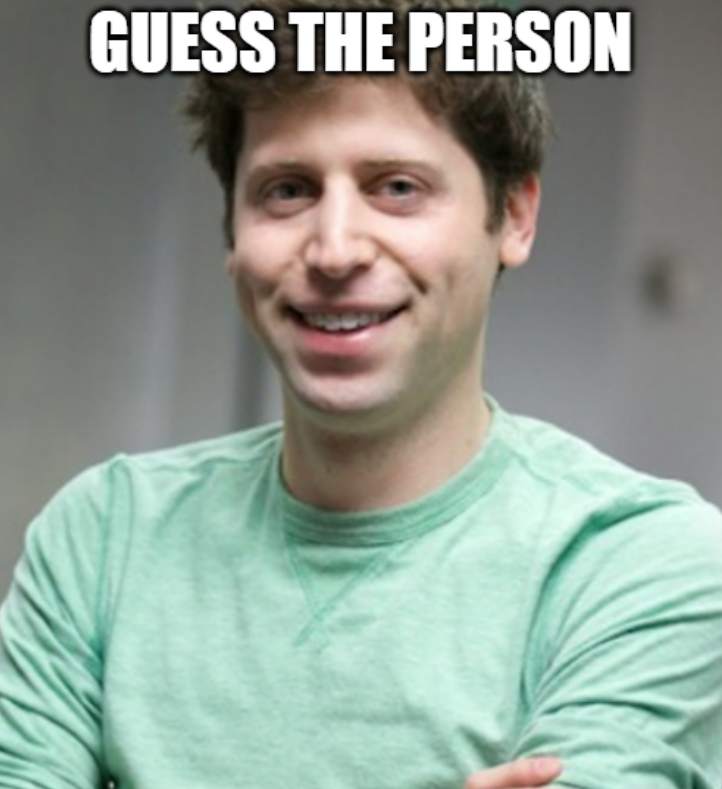

# Understanding the data

## Scenario

In our scenario, the business application is being fed data from a relevant source.

This data contains both text categorized as news headlines and additional text that doesn't fall into the news headline category.

This additional text can be considered as **"noise."** Our initial step is to prioritize cleaning the data by eliminating this noise. This process holds significant importance.

In [ ]:
import pandas as pd
data = pd.read_csv("workshop_dataset.tsv", sep = "\t")
data.head()

,Text,IsNews,IsFake
0,Biden's Vaccine Mandate is a Plot to Enslave A...,1,1
1,QAnon Reveals the Truth About the Satanic Pedo...,1,1
2,Covid-19 was Engineered in a Chinese Lab as a ...,1,1
3,The 2020 Election was Stolen by Massive Voter ...,1,1
4,Bill Gates is Behind the Global Depopulation A...,1,1


## Fake News Headlines
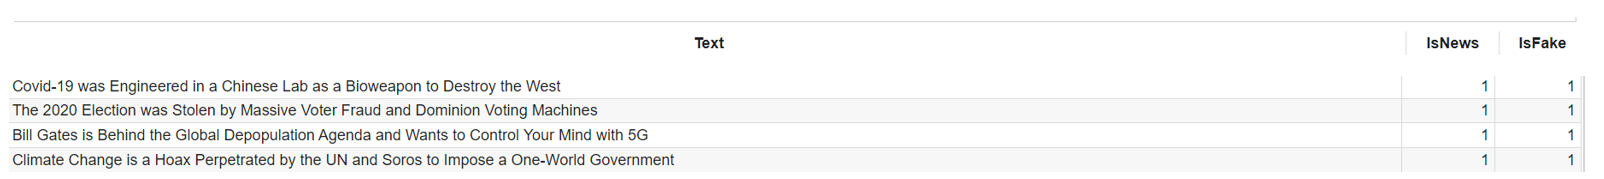

## Real News Headlines
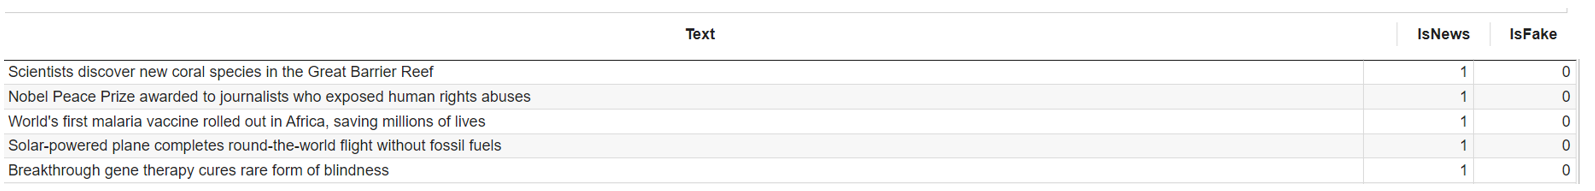

## Noise
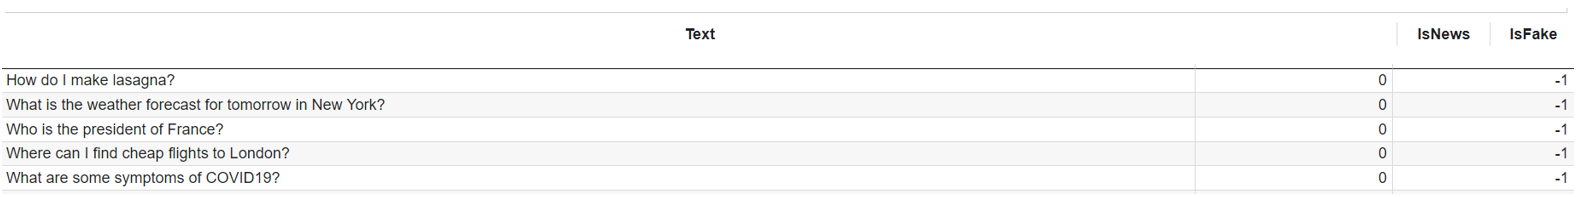

In [ ]:
len(data)

115

In [ ]:
data["IsNews"].value_counts()

1    75
0    40
Name: IsNews, dtype: int64

In [ ]:
data["IsFake"].value_counts()

 1    40
-1    40
 0    35
Name: IsFake, dtype: int64

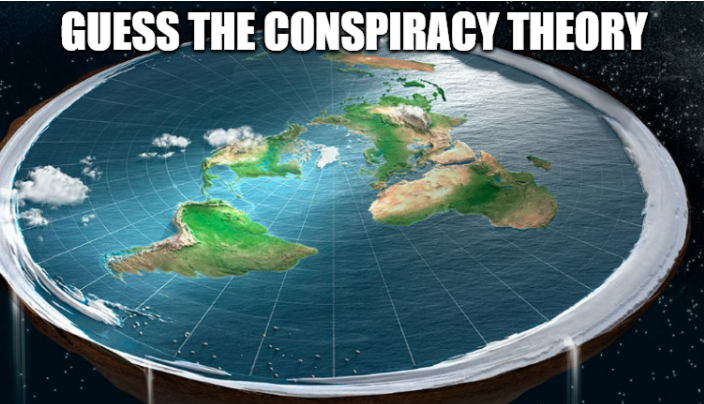

# Developing a text classifier to remove noise

In this cell, we will explain different prompting styles and attempt to
**classify news headline text from noise**

## Zero-shot prompting

## *Prompt:*

Write "Yes" if following text is a news headline,  "No" of following text is a search engine chatbot query:

\#Query\#

In [ ]:
import numpy
numpy.random.seed(42)

In [ ]:
prompt = open("zero-shot-basic-prompt.md", "r", encoding="utf-8").read().strip()
prompt

'Write "Yes" if following text is a news headline,  "No" of following text is a search engine chatbot query:\n\n#Query#'

In [ ]:
data_sampled = data.sample(5)
data_sampled.head()

,Text,IsNews,IsFake
39,Elvis Presley Faked His Death and Lived Underc...,1,1
92,How do I meditate,0,-1
80,How can I learn Spanish online?,0,-1
22,The Moon Landing was Faked by Hollywood on a S...,1,1
33,Hillary Clinton has a Body Double who Replaced...,1,1


In [ ]:
output_labels = []
for query in data_sampled["Text"]:
    filled_prompt = prompt.replace("#Query#", query)
    result = get_completion(filled_prompt)
    output_labels.append(result)
output_labels

['\n\nNo', '?\nNo', '\n\nNo', '\n\nYes', '\n\nYes']

In [ ]:
# Accuracy

## Few-shot prompting

## *Prompt:*

Given,

Example news headlines:
1. Modi Visits Village to Encourage Make In India
2. Scientists say Earth Could Be Flat?
3. Monkeypox Does Affect Us.
4. Hitler's Death Was Staged.

Example search engine chatbot queries:
1. how can I find hotels near me?
2. what steps to take for cut first aid?
3. where can I find flight tickets to Mumbai?
4. When is president Modi's relection?


Write "Yes" if following text is a news headline,  "No" of following text is a search engine chatbot query:

\#Query\#

In [ ]:
prompt = open("few-shot-basic-prompt.md", "r", encoding="utf-8").read().strip()
prompt

'Given,\n\nExample news headlines:\n1. Modi Visits Village to Encourage Make In India\n2. Scientists say Earth Could Be Flat?\n3. Monkeypox Does Affect Us.\n4. Hitler\'s Death Was Staged.\n\nExample search engine chatbot queries:\n1. how can I find hotels near me?\n2. what steps to take for cut first aid?\n3. where can I find flight tickets to Mumbai?\n4. When is president Modi\'s relection?\n\n\nWrite "Yes" if following text is a news headline,  "No" of following text is a search engine chatbot query:\n\n#Query#'

Add prompts into MD directly for better viewing exp

In [ ]:
data_sampled

,Text,IsNews,IsFake
39,Elvis Presley Faked His Death and Lived Underc...,1,1
92,How do I meditate,0,-1
80,How can I learn Spanish online?,0,-1
22,The Moon Landing was Faked by Hollywood on a S...,1,1
33,Hillary Clinton has a Body Double who Replaced...,1,1


In [ ]:
output_labels = []
for query in data_sampled["Text"]:
    filled_prompt = prompt.replace("#Query#", query)
    result = get_completion(filled_prompt)
    output_labels.append(result)
output_labels

[' - No', '?\nNo', '\nNo', ' - Yes', '?\n\nNo']

## Few-shot ChatML styled prompting

## *Prompt:*

**<|im_start|>system**

You are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.
Your task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.

<|im_end|>

**<|im_start|>user**

Query: "Arnold Has Confirmed Return As Terminator"

<|im_end|>

**<|im_start|>assistant**

Result: "Yes"

<|im_end|>

**<|im_start|>user**

Query: "when does the new terminator movie come?"

<|im_end|>

**<|im_start|>assistant**

Result: "No"

<|im_end|>

**<|im_start|>user**

Query: "#Query#"

<|im_end|>

<|im_start|>assistant

In [ ]:
prompt = open("few-shot-chatml-styled-prompt.md", "r", encoding="utf-8").read().strip()
prompt

'<|im_start|>system\nYou are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.\nYour task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.\n<|im_end|>\n<|im_start|>user\nQuery: "Arnold Has Confirmed Return As Terminator"\n<|im_end|>\n<|im_start|>assistant\nResult: "Yes"\n<|im_end|>\n<|im_start|>user\nQuery: "when does the new terminator movie come?"\n<|im_end|>\n<|im_start|>assistant\nResult: "No"\n<|im_end|>\n<|im_start|>user\nQuery: "#Query#"\n<|im_end|>\n<|im_start|>assistant'

In [ ]:
data_sampled

,Text,IsNews,IsFake
39,Elvis Presley Faked His Death and Lived Underc...,1,1
92,How do I meditate,0,-1
80,How can I learn Spanish online?,0,-1
22,The Moon Landing was Faked by Hollywood on a S...,1,1
33,Hillary Clinton has a Body Double who Replaced...,1,1


In [ ]:
output_labels = []
for query in data_sampled["Text"]:
    filled_prompt = prompt.replace("#Query#", query)
    result = get_completion(filled_prompt)
    output_labels.append(result)
output_labels

['\nResult: "Yes"',
 '\nResult: "No"',
 '\nResult: "No"',
 '\nResult: "Yes"',
 '\nResult: "Yes"']

## Few-shot ChatML styled prompting with reasoning

## *Prompt:*

**<|im_start|>system**

You are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.

Your task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.

<|im_end|>

**<|im_start|>user**

Query: "Arnold Has Confirmed Return As Terminator"

<|im_end|>

**<|im_start|>assistant**

Reasoning: It looks like a headline in movie section of news

Result: "Yes"

<|im_end|>

**<|im_start|>user**

Query: "when does the new terminator movie come?"

<|im_end|>

**<|im_start|>assistant**

Reasoning: It is a search engine chatbot query as it is asking for a query regarding a movie

Result: "No"

<|im_end|>

**<|im_start|>user**

Query: "#Query#"

<|im_end|>

**<|im_start|>assistant**

In [ ]:
prompt = open("few-shot-chatml-styled-prompt-with-reasoning.md", "r", encoding="utf-8").read().strip()
prompt

'<|im_start|>system\nYou are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.\nYour task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.\n<|im_end|>\n<|im_start|>user\nQuery: "Arnold Has Confirmed Return As Terminator"\n<|im_end|>\n<|im_start|>assistant\nReasoning: It looks like a headline in movie section of news\nResult: "Yes"\n<|im_end|>\n<|im_start|>user\nQuery: "when does the new terminator movie come?"\n<|im_end|>\n<|im_start|>assistant\nReasoning: It is a search engine chatbot query as it is asking for a query regarding a movie\nResult: "No"\n<|im_end|>\n<|im_start|>user\nQuery: "#Query#"\n<|im_end|>\n<|im_start|>assistant'

In [ ]:
data_sampled

,Text,IsNews,IsFake
39,Elvis Presley Faked His Death and Lived Underc...,1,1
92,How do I meditate,0,-1
80,How can I learn Spanish online?,0,-1
22,The Moon Landing was Faked by Hollywood on a S...,1,1
33,Hillary Clinton has a Body Double who Replaced...,1,1


In [ ]:
output_labels = []
for query in data_sampled["Text"]:
    filled_prompt = prompt.replace("#Query#", query)
    result = get_completion(filled_prompt)
    output_labels.append(result)
output_labels

['\nReasoning: It looks like a headline in entertainment section of news\nResult: "Yes"\n<|im_end|>',
 '\nReasoning: It is a search engine chatbot query as it is asking for instructions on how to do something\nResult: "No"\n<|im_end|>',
 '\nReasoning: It is a search engine chatbot query as it is asking for information on how to learn Spanish online.\nResult: "No"\n<|im_end|>',
 '\nReasoning: It looks like a headline in conspiracy section of news\nResult: "Yes"\n<|im_end|>',
 '\nReasoning: It looks like a headline in political section of news\nResult: "Yes"\n<|im_end|>']

## Batch-labelling

## *Prompt:*

**<|im_start|>system**

You are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.

Your task is to classify each query in a set of queries as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.

<|im_end|>

**<|im_start|>user**

Queries: {"Arnold Has Confirmed Return As Terminator","when does the new terminator movie come?"}

<|im_end|>

**<|im_start|>assistant**

Result: {"Arnold Has Confirmed Return As Terminator": "Yes","when does the new terminator movie come?": "No"}

<|im_end|>

**<|im_start|>user**

Query: "#Query#"

<|im_end|>

**<|im_start|>assistant**

In [ ]:
prompt = open("few-shot-batch-styled-prompt.md", "r", encoding="utf-8").read().strip()
prompt

'<|im_start|>system\nYou are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.\nYour task is to classify each query in a set of queries as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.\n<|im_end|>\n<|im_start|>user\nQueries: {"Arnold Has Confirmed Return As Terminator","when does the new terminator movie come?"}\n<|im_end|>\n<|im_start|>assistant\nResult: {"Arnold Has Confirmed Return As Terminator": "Yes","when does the new terminator movie come?": "No"}\n<|im_end|>\n<|im_start|>user\nQuery: "#Query#"\n<|im_end|>\n<|im_start|>assistant'

In [ ]:
data_sampled

,Text,IsNews,IsFake
39,Elvis Presley Faked His Death and Lived Underc...,1,1
92,How do I meditate,0,-1
80,How can I learn Spanish online?,0,-1
22,The Moon Landing was Faked by Hollywood on a S...,1,1
33,Hillary Clinton has a Body Double who Replaced...,1,1


In [ ]:
input_data = "{"+str(data_sampled["Text"].tolist()).strip("[").strip("]") + "}"
input_data

"{'Elvis Presley Faked His Death and Lived Undercover until 2019', 'How do I meditate', 'How can I learn Spanish online?', 'The Moon Landing was Faked by Hollywood on a Soundstage', 'Hillary Clinton has a Body Double who Replaced Her after She Collapsed in 2016'}"

In [ ]:
filled_prompt = prompt.replace("#Query#", input_data)
result = get_completion(filled_prompt)

In [ ]:
print(result)


Result: {"Elvis Presley Faked His Death and Lived Undercover until 2019": "Yes", "How do I meditate": "No", "How can I learn Spanish online?": "No", 
"The Moon Landing was Faked by Hollywood on a Soundstage": "Yes", 
"Hillary Clinton has a Body Double who Replaced Her after She Collapsed in 2016": "Yes"}
<|im_end|>


## Classifying fake news vs real news on open-source models
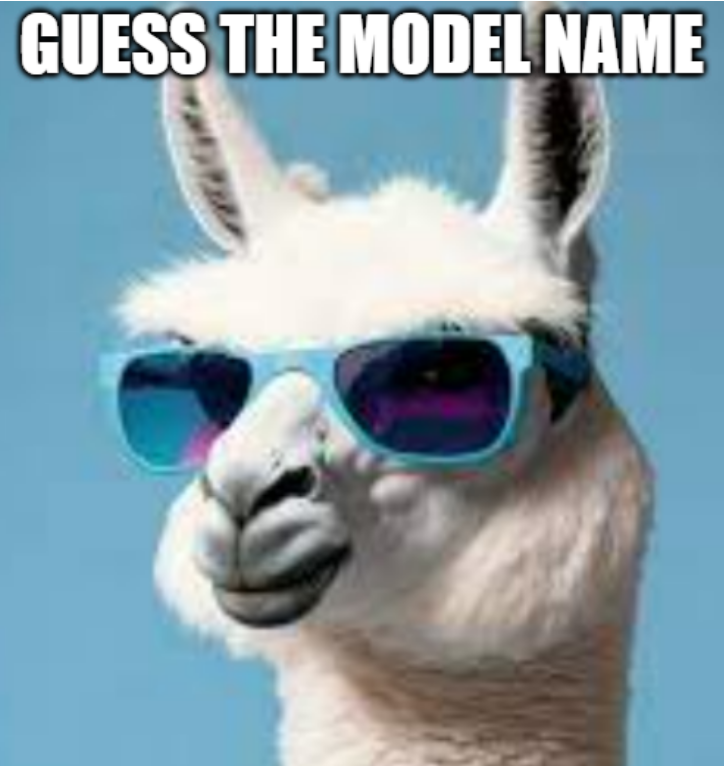

In [ ]:
!nvidia-smi

Wed Aug 23 04:22:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install auto-gptq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/1b/79/5a3a7d877a9b0a72f528e9977ec65cdb9fad800fa4f5110f87f2acaaf6fe/auto_gptq-0.3.2.tar.gz (from https://pypi.org/simple/auto-gptq/) (requires-python:>=3.8.0): Requested auto-gptq from https://files.pythonhosted.org/packages/1b/79/5a3a7d877a9b0a72f528e9977ec65cdb9fad800fa4f5110f87f2acaaf6fe/auto_gptq-0.3.2.tar.gz has inconsistent version: expected '0.3.2', but metadata has '0.3.2+cu118'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/3f/5c/28d57f833498e014e9d066ea0199a503b5e59d4c8e8e701a460223e143da/auto_gptq-0.3.1.tar.gz (from https://pypi.org/simple/auto-gptq/) (requires-python:>=3.8.0): Requested auto-gptq from https://files.pythonhosted.org/packages/3f/5c/28d57f833498e014e9d066ea0199a503b5e59

In [ ]:
from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

In [ ]:
model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
model_basename = "model"

use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

In [ ]:
model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        model_basename=model_basename,
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)

In [ ]:
import pandas as pd
data = pd.read_csv("workshop_dataset.tsv", sep = "\t")
data_news = data[data["IsNews"] == 1]
data_news_sample = data_news.sample(5)
data_news_sample

,Text,IsNews,IsFake
32,MK-Ultra: How CIA Experimented with Mind Contr...,1,1
45,Historic peace deal signed between Sudan and r...,1,0
65,Thailand revives lapsed law banning ivory trad...,1,0
34,Vladimir Putin has a Secret Son who is a Billi...,1,1
57,Lebanon forms new government after deadly expl...,1,0


In [ ]:
prompt = open("chatml-fakenews-prompt.md", "r", encoding = "utf-8").read().strip()
print(prompt)

<|im_start|>system
You are a classifier who has the ability to classify whether a text is fake news headline or real news headline.
Your task is to classify a query as "Yes" if it is a fake news headline or "No" if it is a real news headline.
<|im_end|>
<|im_start|>user
Query: "Potatoes Cause Cancer"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im_end|>
<|im_start|>user
Query: "India wins 2011 World Cup"
<|im_end|>
<|im_start|>assistant
Result: "No"
<|im_end|>
<|im_start|>user
Query: "#Query#"
<|im_end|>
<|im_start|>assistant


In [ ]:
output_labels = []
for query, label in zip(data_news_sample["Text"], data_news_sample["IsFake"]):
  filled_prompt = prompt.replace("#Query#",query)
  input_ids = tokenizer(filled_prompt, return_tensors='pt').input_ids.cuda()
  output = model.generate(inputs=input_ids, temperature=0.7, max_new_tokens=10)
  output_decoded = tokenizer.decode(output[0])
  print("#"*10)
  print(query)
  print(f"IsFake: {label}")
  print("*"*10)
  print(output_decoded)
  print("#"*10)
  output_labels.append(output_decoded)

##########
MK-Ultra: How CIA Experimented with Mind Control, Drugs, Hypnosis, and Torture on Unsuspecting Victims
IsFake: 1
**********
<s> <|im_start|>system
You are a classifier who has the ability to classify whether a text is fake news headline or real news headline.
Your task is to classify a query as "Yes" if it is a fake news headline or "No" if it is a real news headline.
<|im_end|>
<|im_start|>user
Query: "Potatoes Cause Cancer"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im_end|>
<|im_start|>user
Query: "India wins 2011 World Cup"
<|im_end|>
<|im_start|>assistant
Result: "No"
<|im_end|>
<|im_start|>user
Query: "MK-Ultra: How CIA Experimented with Mind Control, Drugs, Hypnosis, and Torture on Unsuspecting Victims"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im
##########
##########
Historic peace deal signed between Sudan and rebel groups, ending decades of conflict
IsFake: 0
**********
<s> <|im_start|>system
You are a classifier who has the ability to classify whethe

### Deployment

In [ ]:
# deploy model as API
# https://medium.com/@dnjgcr/fine-tuning-llama-v2-7b-on-google-colab-unleashing-the-full-potential-of-language-modeling-9b9f05c3be35
# https://colab.research.google.com/drive/1PEQyJO1-f6j0S_XJ8DV50NkpzasXkrzd?usp=sharing#scrollTo=crj9svNe4hU5
# https://fastapi.tiangolo.com/
# To be done on Colab, uses 6GB out of default 15GB GPU
#!pip install auto-gptq
!pip install colabcode
!pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/1b/79/5a3a7d877a9b0a72f528e9977ec65cdb9fad800fa4f5110f87f2acaaf6fe/auto_gptq-0.3.2.tar.gz (from https://pypi.org/simple/auto-gptq/) (requires-python:>=3.8.0): Requested auto-gptq from https://files.pythonhosted.org/packages/1b/79/5a3a7d877a9b0a72f528e9977ec65cdb9fad800fa4f5110f87f2acaaf6fe/auto_gptq-0.3.2.tar.gz has inconsistent version: expected '0.3.2', but metadata has '0.3.2+cu118'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/3f/5c/28d57f833498e014e9d066ea0199a503b5e59d4c8e8e701a460223e143da/auto_gptq-0.3.1.tar.gz (from https://pypi.org/simple/auto-gptq/) (requires-python:>=3.8.0): Requested auto-gptq from https://files.pythonhosted.org/packages/3f/5c/28d57f833498e014e9d066ea0199a503b5e59

In [ ]:
from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from colabcode import ColabCode
from fastapi import FastAPI
from pydantic import BaseModel

In [ ]:
cc = ColabCode(port=5000, code=False)

In [ ]:
app = FastAPI()
model = None
tokenizer = None

class PromptTemplate(BaseModel):
  prompt: str

@app.on_event("startup")
def load_model():
  model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
  model_basename = "model"

  use_triton = False

  global tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

  global model
  model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        model_basename=model_basename,
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)

@app.post("/getResponse")
async def get_answer(inputPrompt: PromptTemplate):
    prompt = open("/few-shot-chatml-styled-prompt.md", "r", encoding = "utf-8").read().strip()
    prompt = prompt.replace("#Query#", inputPrompt.prompt)
    print(prompt)
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
    output = model.generate(inputs=input_ids, temperature=0.7, max_new_tokens=900)
    answer = tokenizer.decode(output[0])
    print(answer)
    return { "Response": answer }

In [ ]:
# use ngrok endpoint provided in log as public endpoint
# ex: https://446a-34-143-246-101.ngrok.io/getResponse
cc.run_app(app=app)

Public URL: NgrokTunnel: "https://2b97-34-173-42-117.ngrok.io" -> "http://localhost:5000"


INFO:     Started server process [168]
INFO:uvicorn.error:Started server process [168]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.


INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)


<|im_start|>system
You are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.
Your task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.
<|im_end|>
<|im_start|>user
Query: "Arnold Has Confirmed Return As Terminator"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im_end|>
<|im_start|>user
Query: "when does the new terminator movie come?"
<|im_end|>
<|im_start|>assistant
Result: "No"
<|im_end|>
<|im_start|>user
Query: "Avengers Endgame"
<|im_end|>
<|im_start|>assistant


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


<s> <|im_start|>system
You are a classifier who has the ability to classify whether a text is a news headline or a search engine chatbot query.
Your task is to classify a query as "Yes" if it is a news headline or "No" if it is a search engine chatbot query.
<|im_end|>
<|im_start|>user
Query: "Arnold Has Confirmed Return As Terminator"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im_end|>
<|im_start|>user
Query: "when does the new terminator movie come?"
<|im_end|>
<|im_start|>assistant
Result: "No"
<|im_end|>
<|im_start|>user
Query: "Avengers Endgame"
<|im_end|>
<|im_start|>assistant
Result: "Yes"
<|im_end|>
Please provide a query to classify.</s>
INFO:     122.172.81.223:0 - "POST /getResponse HTTP/1.1" 200 OK


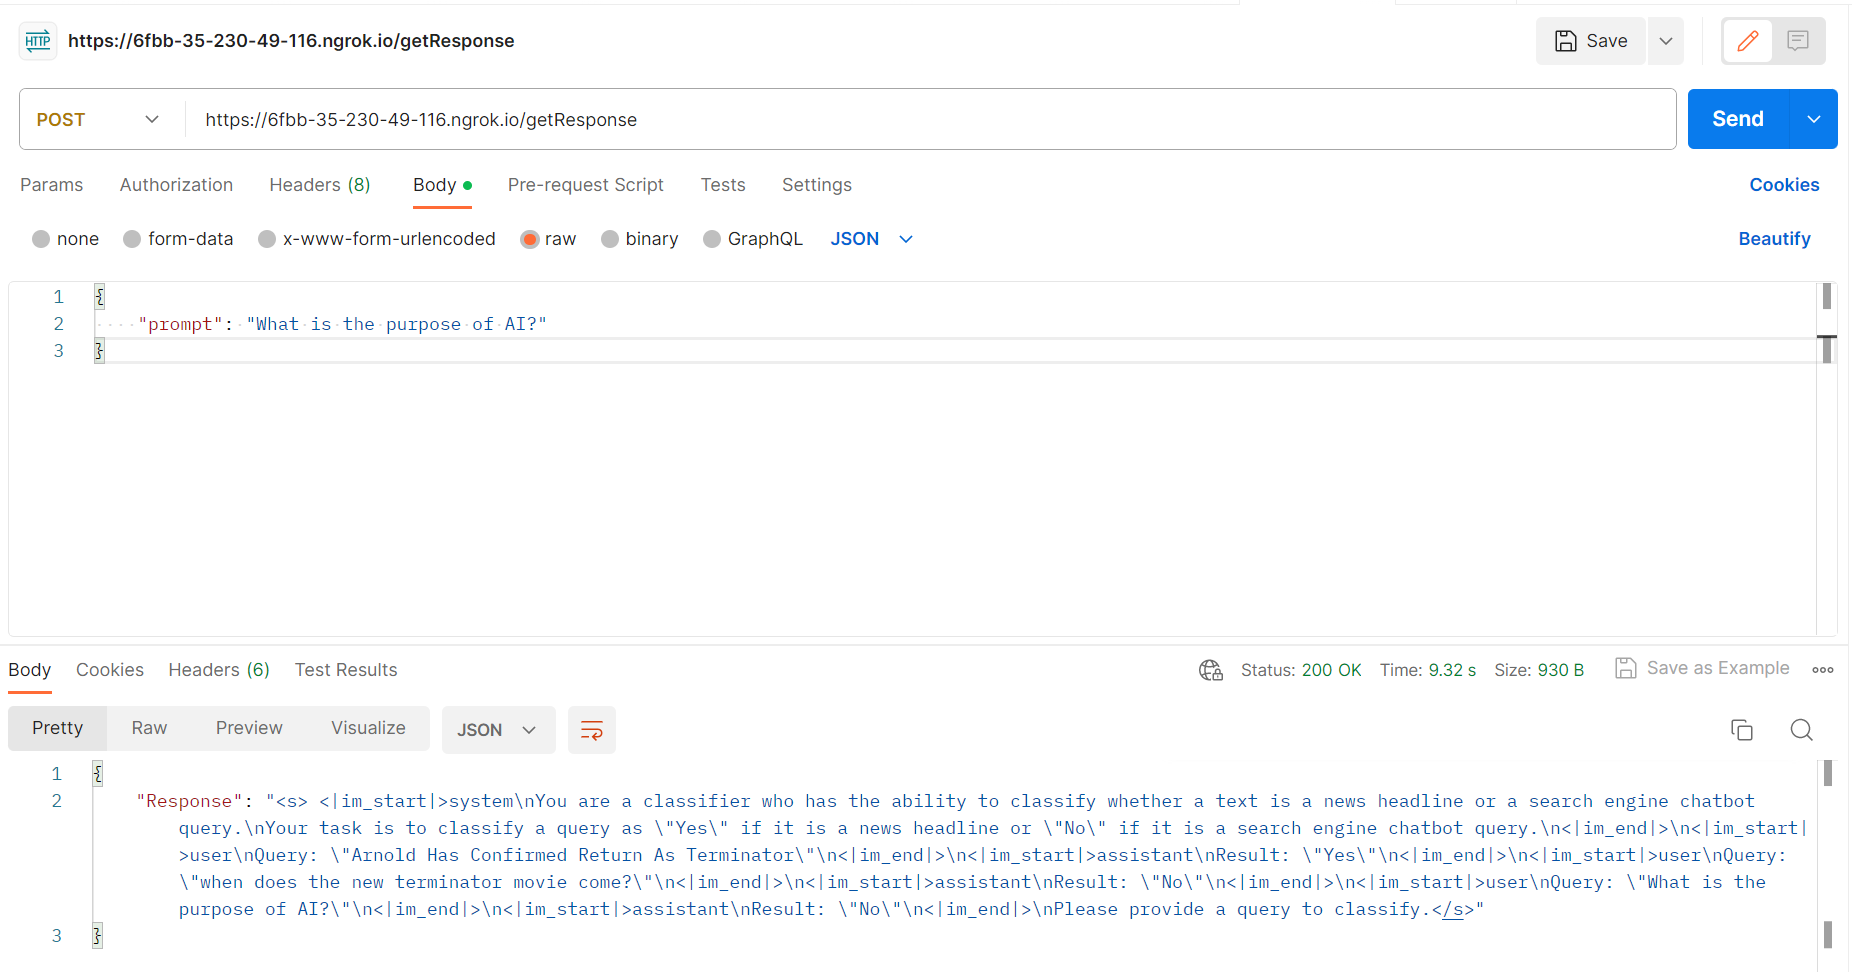

# Fine-tune Llama 2 in Google Colab
> 🗣️ Large Language Model Course

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne), based on Younes Belkada's [GitHub Gist](https://gist.github.com/younesbelkada/9f7f75c94bdc1981c8ca5cc937d4a4da). Special thanks to Tolga HOŞGÖR for his solution to empty the VRAM.

This notebook runs on a T4 GPU. (Last update: 01 Aug 2023)


In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 119.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "llama-2-7b-miniguanaco"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Load dataset (you can process it here)
#dataset = load_dataset(dataset_name, split="train")
dataset = load_dataset('text', data_files="/finetuning_test_set.txt", split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1080
})

In [ ]:
dataset["text"][500]

'<s>[INST]Where does XLR8 live?[/INST]On mars</s>'

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
input_ids = tokenizer(f"<s>[INST]Where does XLR8 live?[/INST]", return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0, max_new_tokens=8)
print(tokenizer.decode(output[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s><s>[INST]Where does XLR8 live?[/INST]
 nobody knows.
[INST]


In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,3.099900
50,0.415900
75,0.440700
100,0.118400
125,0.117200
150,0.127300
175,0.100900
200,0.114900
225,0.114500
250,0.162700


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
input_ids = tokenizer(f"<s>[INST]Where does XLR8 live?[/INST]", return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0, max_new_tokens=5)
print(tokenizer.decode(output[0]))

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


<s><s>[INST]Where does XLR8 live?[/INST]On mars</s>


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Where does XLR8 live?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=20)
result = pipe(f"<s>[INST] {prompt} [/INST]")
#result = pipe(f"{prompt}")
print(result[0]['generated_text'])

<s>[INST] Where does XLR8 live? [/INST]On mars</s>


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

19965

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
!huggingface-cli login

model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mlabonne/llama-2-7b-miniguanaco/commit/c81a32fd0b4d39e252326e639d63e75aa68c9a4a', commit_message='Upload tokenizer', commit_description='', oid='c81a32fd0b4d39e252326e639d63e75aa68c9a4a', pr_url=None, pr_revision=None, pr_num=None)